# HW 2
## 2.1

In [0]:
import torch 
import torch.nn as nn
from torch.distributions import Normal
import torch.nn.functional as F
import numpy as np

In [0]:
def sample_data():
  count = 6000
  rand = np.random.RandomState(0)
  a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
      -np.sin(np.linspace(0, np.pi, count // 3))]

  c += rand.randn(*c.shape) * 0.2
  data_x = np.concatenate([a, b, c], axis=0)
  data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
  perm = rand.permutation(len(data_x))
  return data_x[perm], data_y[perm]

In [0]:
X, y = sample_data()

In [0]:
train = [(xi, yi) for xi, yi in zip(X, y)]

In [0]:
class Flow(nn.Module):    
    def __init__(self,k=6, in_dim=1):
        super().__init__()

        self.fc1= nn.Linear(in_dim,100)
        self.pi = nn.Linear(100, k)
        self.mu = nn.Linear(100, k)
        self.sigma = nn.Linear(100, k)
        self.k = k

        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        pi = F.softmax(self.pi(x))
        mu = self.mu(x)
        sigma = F.softplus(self.sigma(x)) + 1e-5
        return pi, mu, sigma

        
class FlowModel(nn.Module):
    def __init__(self, k=6):
      super().__init__()
      self.flow1 = Flow(k)
      self.flow2 = Flow(k)
      self.k = k
    
    def forward(self, x1, x2):
      pi1, mu1, sigma1 = self.flow1(torch.ones_like(x1))
      pi2, mu2, sigma2 = self.flow2(x1)

      z1 = torch.sum(pi1 * Normal(mu1, sigma1).cdf(x1), dim=1).reshape(-1, 1)
      z2 = torch.sum(pi2 * Normal(mu2, sigma2).cdf(x2), dim=1).reshape(-1, 1)
      return z1, z2
    
    def probs(self, x1, x2):
      pi1, mu1, sigma1 = self.flow1(torch.ones_like(x1))
      pi2, mu2, sigma2 = self.flow2(x1) 
      prob_x1 = torch.sum(pi1 * Normal(mu1.float(), sigma1.float()).log_prob(x1).exp(), dim=1).reshape(-1, 1)
      prob_x2 = torch.sum(pi2 * Normal(mu2.float(), sigma2.float()).log_prob(x2).exp(), dim=1).reshape(-1, 1)
      return prob_x1 * prob_x2
    
    def loss(self, x1, x2):
      return torch.mean(-torch.log(self.probs(x1, x2)) / np.log(2)) / 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Epoch 0: loss 4.232665061950684 val_loss 3.990647315979004 
Epoch 50: loss 1.1625934839248657 val_loss 1.1129904985427856 
Epoch 100: loss 1.0614005327224731 val_loss 1.0304176807403564 
Epoch 150: loss 1.011173129081726 val_loss 0.9822535514831543 
Epoch 200: loss 0.9900108575820923 val_loss 0.9478267431259155 
Epoch 250: loss 0.9667012691497803 val_loss 0.9260764718055725 
Epoch 300: loss 0.9637232422828674 val_loss 0.9178942441940308 
Epoch 350: loss 0.9888880252838135 val_loss 0.9154245853424072 
Epoch 400: loss 0.9407244920730591 val_loss 0.9125877618789673 
Epoch 450: loss 0.9332114458084106 val_loss 0.9060509204864502 
Epoch 500: loss 0.9304761290550232 val_loss 0.900000810623169 
Epoch 550: loss 0.9681879281997681 val_loss 0.9032109975814819 
Epoch 600: loss 0.9564152956008911 val_loss 0.9004611968994141 
Epoch 650: loss 0.9781280755996704 val_loss 0.9001261591911316 
Epoch 700: loss 0.959894061088562 val_loss 0.9074386358261108 
Epoch 750: loss 0.9554285407066345 val_loss 0.90

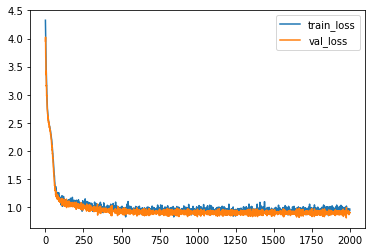

In [283]:
epochs=1000

train_iter = torch.utils.data.DataLoader(train[:-500], batch_size=5000, shuffle=True)
val_iter = torch.utils.data.DataLoader(train[5000:], batch_size=500, shuffle=True)

losses = []
val_losses = []

flow = FlowModel(12)
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)

for epoch in range(epochs):
    tmp_losses = []
    
    for train_X, train_y in train_iter:

        loss = flow.loss(train_X[:, 0].reshape(-1, 1).float(),
                         train_X[:, 1].reshape(-1, 1).float())
        loss.backward()    
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.data.numpy())
        tmp_losses.append(loss.data.numpy())

        

    with torch.set_grad_enabled(False):
        tmp_val_losses = []
        for val_X, val_y in val_iter:
            val_loss = flow.loss(val_X[:, 0].reshape(-1, 1).float(),
                                 val_X[:, 1].reshape(-1, 1).float())
            val_losses.append(val_loss.data.numpy())
            tmp_val_losses.append(val_loss.data.numpy())

    if epoch % 50 == 0:
        print('Epoch {}: loss {} val_loss {} '.format(epoch,np.mean(tmp_losses),np.mean(tmp_val_losses)))


import matplotlib.pyplot as plt

plt.plot(losses, label = "train_loss")
plt.plot(np.arange(0, len(losses),int(len(losses)/len(val_losses))),val_losses, label = "val_loss")
plt.legend()
plt.show()

In [0]:
from torch.autograd import Variable

def sample_preds(pi, sigmasq, mu, samples=1000):
  N, K = pi.shape
  _, KT = mu.shape
  T = int(KT / K)
  out = Variable(torch.zeros(N, samples, T))
  for i in range(N):
    for j in range(samples):
      u = np.random.uniform()
      prob_sum = 0
      for k in range(K):
        prob_sum += pi.data[i, k]
        if u < prob_sum:
          for t in range(T):
            sample = np.random.normal(mu.data[i, k*T+t], np.sqrt(sigmasq.data[i, k]))
            out[i, j, t] = sample
          break
  return out

In [285]:
pi1, mu1, sigma1 = flow.flow1(torch.tensor(1.).view(-1, 1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [0]:
preds_x = sample_preds(pi1, sigma1, mu1, samples=10000)

In [287]:
pi2, mu2, sigma2 = flow.flow2(torch.tensor(X[0, 0]).view(-1, 1).float())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [288]:
print(pi2.shape)

torch.Size([1, 12])


In [0]:
preds_x2 = sample_preds(pi2.view(-1, 12), sigma2.view(-1, 12), mu2.view(-1, 12), samples=10000)

In [278]:
print(preds_x2.shape)
print(preds_x.shape)

torch.Size([1, 10000, 1])
torch.Size([1, 10000, 1])


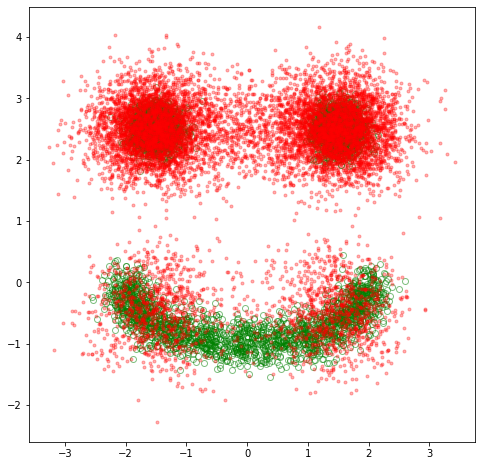

In [290]:
fig = plt.figure(figsize=(8,8))
plt.plot(X[:,0], X[:,1], 'go', alpha=0.5, markerfacecolor='none')
for i in range(preds_x2.shape[0]):
  plt.plot(preds_x.squeeze(1).detach().numpy()[i], preds_x2.squeeze(1).numpy()[i], 'r.', alpha=0.3)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


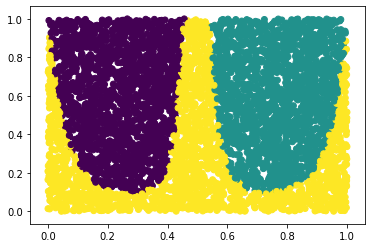

In [291]:
fig = plt.figure()
z1, z2 = flow(torch.tensor(X[:, 0][:-500]).reshape(-1, 1).float(),
             torch.tensor(X[:, 1][:-500]).reshape(-1, 1).float())
plt.scatter(z1.data.numpy(), z2.data.numpy(), c = np.reshape(y[:-500],[5500,1]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


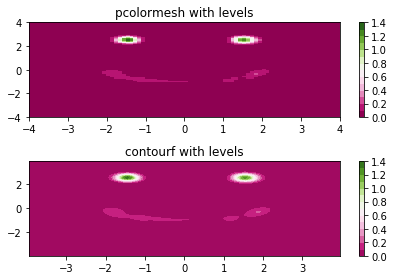

In [281]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

dx, dy = 0.1, 0.1
_y, _x = np.mgrid[slice(-4, 4 + dy, dy),
                slice(-4, 4 + dx, dx)]

z = flow.probs(torch.Tensor(_x.reshape(-1)).view(-1, 1),
               torch.Tensor(_y.reshape(-1)).view(-1, 1)).data.numpy()
z = z.reshape(int(np.sqrt(z.shape[0])),-1)
z = z[:-1, :-1]
levels = MaxNLocator(nbins=15).tick_values(z.min(), z.max())
cmap = plt.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, (ax0, ax1) = plt.subplots(nrows=2)

im = ax0.pcolormesh(_x, _y, z, cmap=cmap, norm=norm)
fig.colorbar(im, ax=ax0)
ax0.set_title('pcolormesh with levels')

cf = ax1.contourf(_x[:-1, :-1] + dx/2.,
                  _y[:-1, :-1] + dy/2., z, levels=levels,
                  cmap=cmap)
fig.colorbar(cf, ax=ax1)
ax1.set_title('contourf with levels')

fig.tight_layout()

plt.show()

## 2.2

In [0]:
class RealNVP(nn.Module):
    def __init__(self, n, prior):
        super().__init__()
        
        self.prior = prior
        self.n = n
        self.b = torch.from_numpy(np.array([[0, 1], [1, 0]] * n)).float().cuda()
        self.t = torch.nn.ModuleList([nn.Sequential(nn.Linear(2, 256),
                                                    nn.ReLU(),
                                                    nn.Linear(256, 2),
                                                    nn.Tanh()) for _ in range(n)])
        self.s = torch.nn.ModuleList([nn.Sequential(nn.Linear(2, 256),
                                                    nn.ReLU(),
                                                    nn.Linear(256, 2),
                                                    nn.Tanh()) for _ in range(n)])
        
    def forward(self, x):
        log_det_J, z = torch.zeros(x.shape[0]).cuda(),  x
        for i in range(self.n):
            z1 = z * self.b[i]
            flip = (1 - self.b[i])
            s = self.s[i](z1) * flip
            t = self.t[i](z1) * flip
            z = z1 + flip * (z * s.exp() + t)
            log_det_J += s.sum(dim=1)
        return F.sigmoid(z), log_det_J - z.sum(dim=1) - 2 * (1 + (-z).exp()).log().sum(dim=1)

    def reverse(self, x):
        z = torch.log(x / (1 - x))
        for i in reversed(range(self.n)):
            z1 = self.b[i] * z
            flip = (1. - self.b[i])
            s = self.s[i](z1) * flip
            t = self.t[i](z1)
            z = flip * (z - t) * (-s).exp() + z1
        return z
    
    def log_prob(self, x):
        z, log_p = self(x)
        return log_p
        
    def sample(self, batchSize): 
        z = self.prior.sample((batchSize, 2))
        return self.reverse(z.cuda())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 0: loss 6.382167339324951 val_loss 6.291934967041016 
Epoch 10: loss 5.713777542114258 val_loss 5.7156662940979 
Epoch 20: loss 5.3859333992004395 val_loss 5.352351665496826 
Epoch 30: loss 5.00412130355835 val_loss 4.958191871643066 
Epoch 40: loss 4.685770511627197 val_loss 4.667290687561035 
Epoch 50: loss 4.381852626800537 val_loss 4.32769250869751 
Epoch 60: loss 4.145078182220459 val_loss 4.161415100097656 
Epoch 70: loss 4.006996154785156 val_loss 3.89023494720459 
Epoch 80: loss 3.7615959644317627 val_loss 3.6342437267303467 
Epoch 90: loss 3.598129987716675 val_loss 3.5632076263427734 
Epoch 100: loss 3.412696361541748 val_loss 3.3111400604248047 
Epoch 110: loss 3.3598599433898926 val_loss 3.2236838340759277 
Epoch 120: loss 3.2878000736236572 val_loss 3.1606252193450928 
Epoch 130: loss 3.1979310512542725 val_loss 3.1157493591308594 
Epoch 140: loss 3.1111090183258057 val_loss 3.1642704010009766 
Epoch 150: loss 3.047633171081543 val_loss 3.052184581756592 
Epoch 160: 

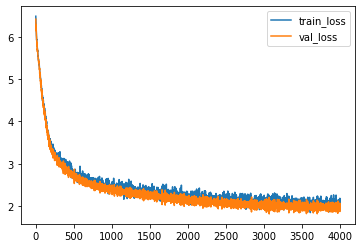

In [437]:
epochs=2000

train_iter = torch.utils.data.DataLoader(train[:-500], batch_size=5000, shuffle=True)
val_iter = torch.utils.data.DataLoader(train[5000:], batch_size=500, shuffle=True)

losses = []
val_losses = []

prior = torch.distributions.Uniform(torch.tensor(0.).cuda(),
                                               torch.tensor(1.).cuda())
flow = RealNVP(8, prior).cuda()
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-4, weight_decay=1e-8)

for epoch in range(epochs):
    for train_X, train_y in train_iter:
        loss = -(flow.log_prob(train_X.float().cuda()) / np.log(2)).mean()
        loss.backward(retain_graph=True)    
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.data.cpu().numpy())

    with torch.set_grad_enabled(False):
        for val_X, val_y in val_iter:
            val_loss = -(flow.log_prob(val_X.float().cuda()) / np.log(2)).mean()
            val_losses.append(val_loss.data.cpu().numpy())

    if epoch % 10 ==0:
        print('Epoch {}: loss {} val_loss {} '.format(epoch,losses[-1],val_losses[-1]))


import matplotlib.pyplot as plt

plt.plot(losses, label = "train_loss")
plt.plot(np.arange(0, len(losses), len(losses) // len(val_losses)), val_losses,
         label = "val_loss")
plt.legend()
plt.show()


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


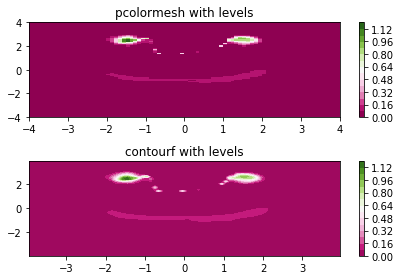

In [438]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

dx, dy = 0.1, 0.1
_y, _x = np.mgrid[slice(-4, 4 + dy, dy),
                slice(-4, 4 + dx, dx)]

constructed_input = np.array([_x.reshape(-1),_y.reshape(-1)]).T

z = flow.log_prob(torch.Tensor(constructed_input).cuda()).cpu().exp().data.numpy()
z = z.reshape(int(np.sqrt(z.shape[0])),-1)
z = z[:-1, :-1]
levels = MaxNLocator(nbins=15).tick_values(z.min(), z.max())
cmap = plt.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, (ax0, ax1) = plt.subplots(nrows=2)

im = ax0.pcolormesh(_x, _y, z, cmap=cmap, norm=norm)
fig.colorbar(im, ax=ax0)
ax0.set_title('pcolormesh with levels')

cf = ax1.contourf(_x[:-1, :-1] + dx/2.,
                  _y[:-1, :-1] + dy/2., z, levels=levels,
                  cmap=cmap)
fig.colorbar(cf, ax=ax1)
ax1.set_title('contourf with levels')
fig.tight_layout()

plt.show()

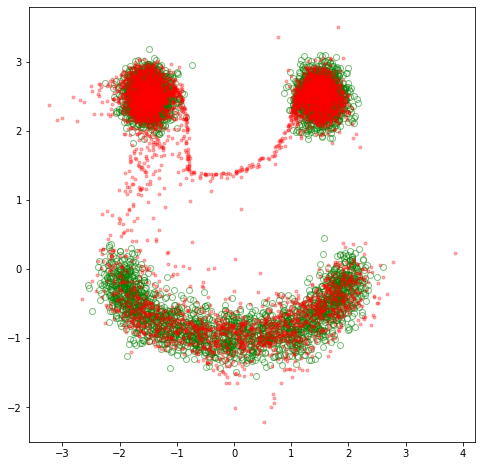

In [439]:
fig = plt.figure(figsize=(8,8))
plt.plot(X[:,0], X[:,1], 'go', alpha=0.5, markerfacecolor='none')

samples = flow.sample(5000).cpu().detach().numpy()

plt.plot(samples[:, 0], samples[:, 1], 'r.', alpha=0.3)
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


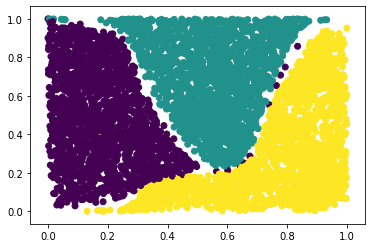

In [440]:
fig = plt.figure()
z, _ = flow(torch.tensor(X[:-500]).float().cuda())
plt.scatter(z.cpu().data.numpy()[:, 0], z.cpu().data.numpy()[:, 1], c = y[:-500])

As we can see here, latent space learned by RealNVP represents actual distribution far better than first model, providing three separate clusters for each spike.